In [1]:
from omegaconf import OmegaConf
from pathlib import Path
import pandas as pd
from multiprocessing import Pool

config_folder = Path("../carps/configs/problem")
paths = list(config_folder.glob("**/*.yaml"))
paths = [p for p in paths if "DUMMY" not in str(p)]

def read_task(p) -> dict:
    cfg = OmegaConf.load(p)
    task = OmegaConf.to_container(cfg.task)
    task["benchmark_id"] = cfg.benchmark_id
    task["problem_id"] = cfg.problem_id
    return task

with Pool() as pool:
    tasks = pool.map(read_task, paths)
tasks = pd.DataFrame(tasks)

In [2]:
list(tasks.columns)

['n_trials',
 'time_budget',
 'n_workers',
 'n_objectives',
 'objectives',
 'is_multifidelity',
 'fidelity_type',
 'min_budget',
 'max_budget',
 'has_constraints',
 'domain',
 'objective_function_approximation',
 'has_virtual_time',
 'deterministic',
 'dimensions',
 'search_space_n_categoricals',
 'search_space_n_ordinals',
 'search_space_n_integers',
 'search_space_n_floats',
 'search_space_has_conditionals',
 'search_space_has_forbiddens',
 'search_space_has_priors',
 'benchmark_id',
 'problem_id']

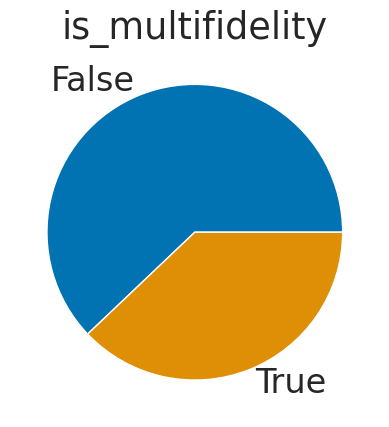

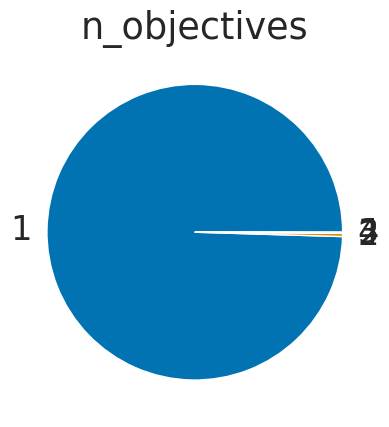

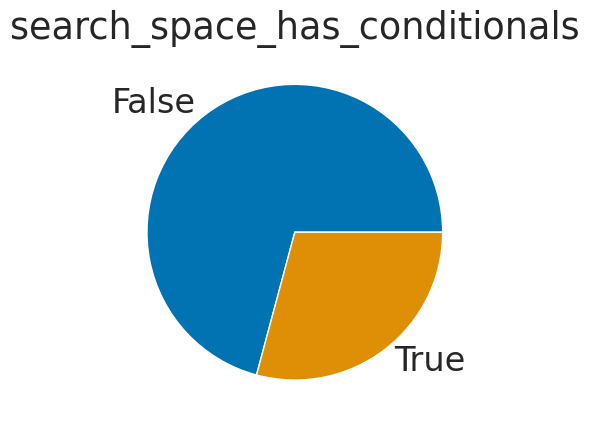

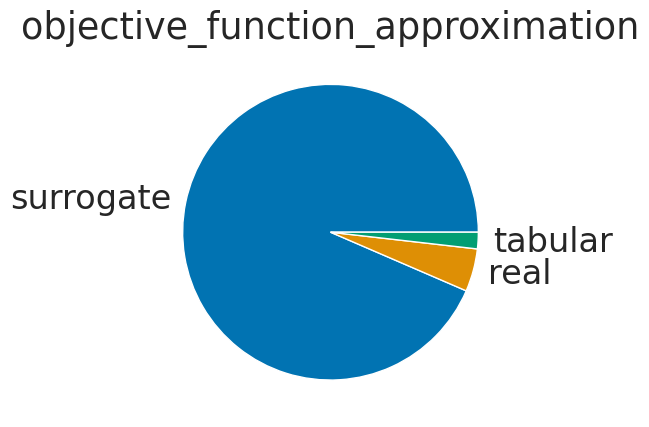

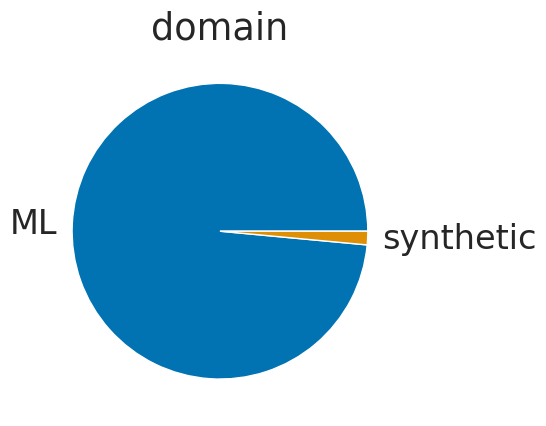

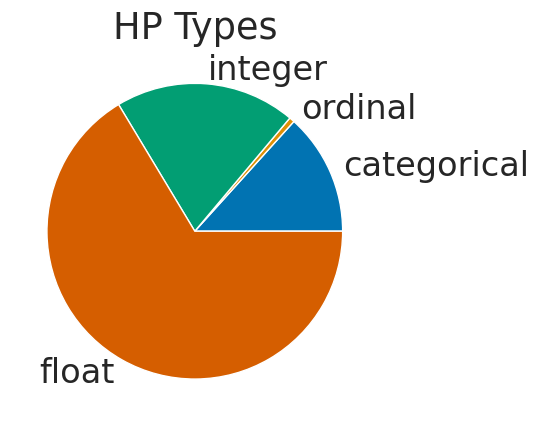

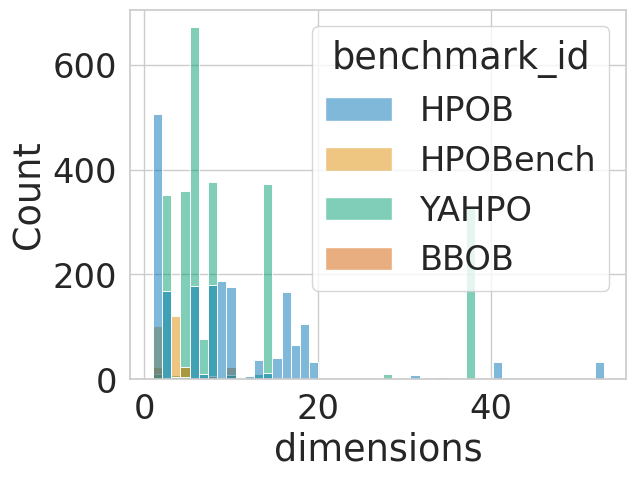

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sns.set(font_scale=2.2)
sns.set_style("whitegrid")
sns.set_palette("colorblind")




n_multiobjective = np.sum(tasks["n_objectives"] > 1)
n_multifidelity = np.sum(~tasks["fidelity_type"].isna())
n_conditional_search_spaces = np.sum(tasks["search_space_has_conditionals"])
n_tasks = len(tasks)


def make_pie(n: int, total: int, identifier: str):
    fig, ax = plt.subplots()
    sizes = [int(n), int(total - n)]
    labels = [f"{identifier} ({n*100/total:.0f}%)", "total"]
    ax.pie(sizes, labels=labels)
    plt.show()


def savefig(fnbase: str, fig):
    extensions = [".pdf", ".png"]
    for extension in extensions:
        fn = Path(fnbase + extension)
        fn.parent.mkdir(exist_ok=True, parents=True)
        fig.savefig(fn, dpi=300, bbox_inches="tight")


def plot_pie_value_counts(tasks: pd.DataFrame, key_column: str):
    fig, ax = plt.subplots()
    value_counts = tasks[key_column].value_counts()
    sizes = value_counts.values
    labels = list(value_counts.index)
    ax.pie(sizes, labels=labels)
    ax.set_title(key_column)
    savefig(f"figures/benchmarks/pie_{key_column}", fig)
    plt.show()

def plot_pie_hp_types(tasks: pd.DataFrame):
    fig, ax = plt.subplots()
    sizes = [tasks["search_space_n_categoricals"].sum(), tasks["search_space_n_ordinals"].sum(), tasks["search_space_n_integers"].sum(), tasks["search_space_n_floats"].sum()]
    labels = ["categorical", "ordinal", "integer", "float"]
    ax.pie(sizes, labels=labels)
    ax.set_title("HP Types")
    savefig(f"figures/benchmarks/pie_HPtypes", fig)
    plt.show()

def plot_dimensions(tasks: pd.DataFrame):
    fig, ax = plt.subplots()
    sns.histplot(data=tasks, x="dimensions", hue="benchmark_id")
    savefig(f"figures/benchmarks/histogram_dimensions", fig)
    plt.show()



# sns.histplot(data=tasks, x="fidelity_type")
# plt.show()
# sns.histplot(data=tasks, x="n_objectives")
# plt.show()
plot_pie_value_counts(tasks=tasks, key_column="is_multifidelity")
plot_pie_value_counts(tasks=tasks, key_column="n_objectives")
plot_pie_value_counts(tasks=tasks, key_column="search_space_has_conditionals")
plot_pie_value_counts(tasks=tasks, key_column="objective_function_approximation")
plot_pie_value_counts(tasks=tasks, key_column="domain")
plot_pie_hp_types(tasks)
plot_dimensions(tasks)



